# This notebook is to implement the patch-based optimization to solve the spatial variant problem

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import torch
import os
import signal
import cv2
import scipy.io as sio
import scipy
import imageio
import time
import skimage as sk
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
from opticaltomography.forward_3dri import PhaseObject3D, TomographySolver
from opticaltomography.loss import mse_loss, sparsity_loss, L1_loss, total_variation_loss_2d, mse_loss_np
import opticaltomography.opticsutils_3dri as utils
from opticaltomography.opticsutils_3dri import norm, norm_np, find_min_index, compute_psf_matrix_row

In [3]:
import opticaltomography.opticsutils_3dri

# Compute the Patch-wise PSF convolution

In [4]:
predict_psf_meas_origin = np.load('Result/predict_psf_usaf_100x100.npy')
predict_psf_meas = predict_psf_meas_origin.reshape((100,100,200,200))
#predict_psf_meas /= np.max(predict_psf_meas, axis=(2, 3), keepdims=True)

In [5]:
patch_psf = np.zeros((50,50,80,80))
for i in range(50):
    for j in range(50):
        patch_psf[j,i] = np.roll(predict_psf_meas[i*2,j*2], shift=(50-i*2, 50-j*2), axis=(1,0))[60:140,60:140]
        # patch_psf[j,i] = np.roll(predict_psf_meas[i*2,j*2], shift=(0, 0), axis=(1,0))

In [5]:
patch_psf = np.zeros((100,100,80,80))
for i in range(100):
    for j in range(100):
        patch_psf[j,i] = np.roll(predict_psf_meas[i,j], shift=(50-i, 50-j), axis=(1,0))[60:140,60:140]

interactive(children=(IntSlider(value=0, description='i', max=2499), Output()), _dom_classes=('widget-interact…

<function __main__.updateFrames(i)>

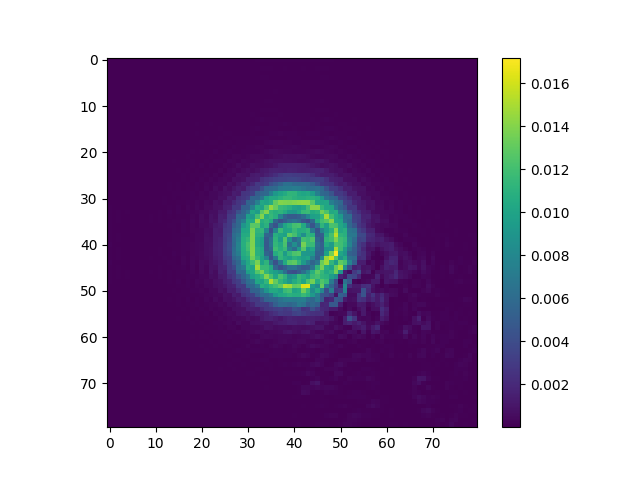

In [6]:
# Imshow ground truth object
f, axes = plt.subplots()
frames = []


def init():
    im_obj = axes.imshow(patch_psf[0,0])
    frames.append(im_obj)
    f.colorbar(im_obj, ax=axes)

init()

def updateFrames(i):
    x = i%100
    y = (i-i%100)//100
    frames[0].set_data(patch_psf[x,y])

interact(updateFrames, i=IntSlider(min=0, max=2499, step=1, value=0))

### Load the settings

In [6]:
usaf = np.array(plt.imread('Dataset/usaf_s.jpeg'))
usaf = sk.color.rgb2gray(cv2.resize(usaf, (50, 50)))
usaf = np.where(usaf > 0.8, 1, 0)
usaf = np.pad(usaf, ((75, 75), (75, 75)), mode='constant', constant_values=0)

In [7]:
meas = np.load('Result/meas.npy')

### Solve inverse problem with optimization

In [8]:
# Set GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device_no = 0
torch.cuda.set_device(device_no)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
torch.cuda.get_device_name()

'NVIDIA TITAN Xp'

In [10]:
recon_obj = torch.zeros((200,200), requires_grad=True, device=device)
patch_psf_tensor = torch.tensor(patch_psf, device=device)
usaf_tensor = torch.tensor(usaf, device=device)
meas_tensor = torch.tensor(meas, device=device)
# pred_forward = torch.zeros((200,200), device=device)
# inter_result = torch.zeros((80,80), device=device)

In [11]:
# Set parameters

n_iters = 50
learning_rate = 0.01

optimizer = torch.optim.Adam([recon_obj], lr=learning_rate)
# optimizer = torch.optim.SGD([recon_obj], lr=learning_rate, momentum=0.9)

losslist = []

In [12]:
for epoch in range(n_iters):
 
    optimizer.zero_grad()
    pred_forward = utils.patch_interp_conv22(recon_obj, patch_psf_tensor, device=device)
    
    total = total_variation_loss_2d(pred_forward, 0.001, device=device)
    mseloss = mse_loss(pred_forward, meas_tensor)
    l1loss = L1_loss(pred_forward, 1e-8)
    loss = total+mseloss+l1loss

    # + total_variation_loss_2d(pred_forward, 1, device=device)
    
    losslist.append(loss)
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        print(f'Reconstruction after iteration {epoch}, loss {mseloss:.4e}, l1 {l1loss:.4e}, tv {total:.4e}')

Reconstruction after iteration 0, loss 1.9289e-02, l1 0.0000e+00, tv 0.0000e+00
Reconstruction after iteration 1, loss 1.4144e-02, l1 7.4100e-06, tv 1.3211e-06
Reconstruction after iteration 2, loss 1.0531e-02, l1 1.1523e-05, tv 2.1713e-06
Reconstruction after iteration 3, loss 7.7969e-03, l1 1.3802e-05, tv 2.8474e-06
Reconstruction after iteration 4, loss 5.7424e-03, l1 1.5644e-05, tv 3.5947e-06
Reconstruction after iteration 5, loss 4.2654e-03, l1 1.7355e-05, tv 4.3576e-06
Reconstruction after iteration 6, loss 3.2554e-03, l1 1.8908e-05, tv 5.0587e-06
Reconstruction after iteration 7, loss 2.5985e-03, l1 2.0220e-05, tv 5.6572e-06
Reconstruction after iteration 8, loss 2.1952e-03, l1 2.1211e-05, tv 6.1489e-06
Reconstruction after iteration 9, loss 1.9642e-03, l1 2.1911e-05, tv 6.5624e-06
Reconstruction after iteration 10, loss 1.8422e-03, l1 2.2374e-05, tv 6.9182e-06
Reconstruction after iteration 11, loss 1.7823e-03, l1 2.2647e-05, tv 7.2317e-06
Reconstruction after iteration 12, los

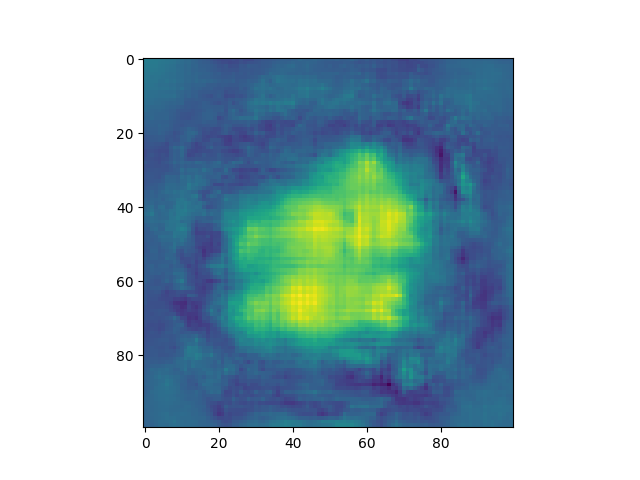

In [13]:
plt.figure()
plt.imshow(recon_obj.detach().cpu()[50:150,50:150])

In [ ]:
np.save('Result/patch_bsed/patch_2_tv0.001_l1e-8_epoch1000.npy',recon_obj.detach().cpu())

In [ ]:
losslist_cpu = [tensor.detach().cpu() for tensor in losslist]
np.save('Result/patch_bsed/patch_2_loss_tv0.001_l1e-8_epoch1000.npy',losslist_cpu)

In [ ]:
psnr_value = psnr(np.array(recon_obj.detach().cpu()[50:150,50:150]).astype(np.float64), usaf[50:150, 50:150].astype(np.float64))
print(psnr_value)
# Compute SSIM (Structural Similarity Index)
ssim_value = ssim(np.array(recon_obj.detach().cpu()[50:150, 50:150]).astype(np.float64), usaf[50:150, 50:150].astype(np.float64))
print(ssim_value)

In [59]:
pred_forward.device

device(type='cpu')

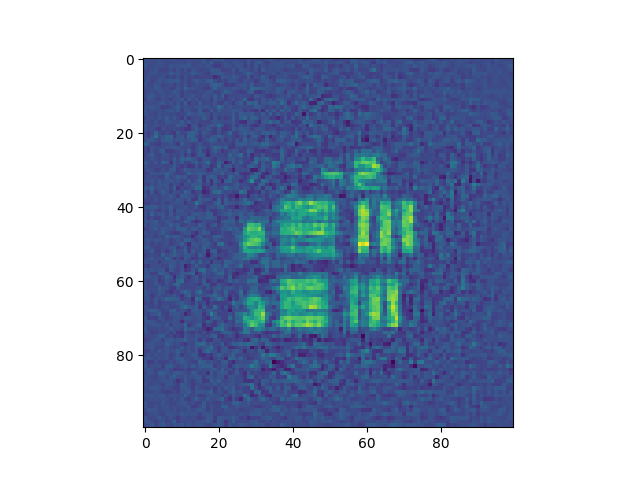

In [16]:
a = np.load('Result/patch_bsed/patch_1_tv10_epoch1000.npy')
plt.figure()
plt.imshow(a[50:150,50:150])

In [17]:
psnr_value = psnr(np.array(a[50:150,50:150].astype(np.float64)), usaf[50:150, 50:150].astype(np.float64))
print(psnr_value)
# Compute SSIM (Structural Similarity Index)
ssim_value = ssim(np.array(a[50:150,50:150].astype(np.float64)), usaf[50:150, 50:150].astype(np.float64))
print(ssim_value)

20.617453808620958
0.6675187884903466


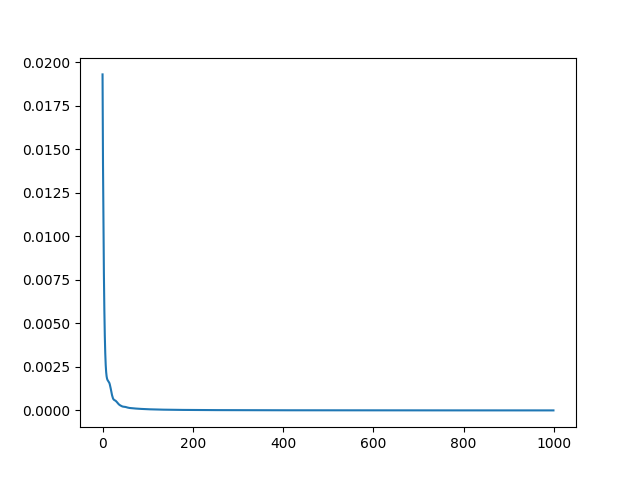

In [8]:
b = np.load('Result/patch_bsed/patch_1_loss_tv10_epoch1000.npy')
plt.figure()
plt.plot(b)

In [19]:
b[-2]

2.9540967315205974e-06